# Raster acquisition, processing and analysis with Databricks

The final notebook in this series will demonstrate how to:
- Use Mosaic's map algebra functions [↗︎](https://databrickslabs.github.io/mosaic/api/raster-functions.html) to compute the pixel-level Normalized Difference Vegetation Index (NDVI) and aggregate this to a single result per AoI.

## Install the libraries and prepare the environment

For this demo we will require a few spatial libraries that can be easily installed via pip install. We will be using gdal, rasterio, pystac and databricks-mosaic for data download and data manipulation. We will use planetary computer as the source of the raster data for the analysis.

In [0]:
import os

notebook_path = dbutils.notebook.entry_point.getDbutils().notebook().getContext().notebookPath().get()
project_path = os.path.dirname(notebook_path)
os.environ["PROJECTCWD"] = project_path

%pip install /Workspace$PROJECTCWD/databricks_mosaic-0.4.3-py3-none-any.whl
%pip install --quiet rasterio==1.3.5 gdal==3.4.1 pystac pystac_client planetary_computer tenacity rich osdatahub

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
import library
import mosaic as mos
import os

from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql import Window

data_product = "OpenGreenspace"

current_user = spark.sql("select current_user() as user").first()["user"]
data_root = f"/tmp/{current_user}/{data_product}/data"
output_path = data_root.replace("/data", "/outputs")

dbutils.fs.mkdirs(data_root)
dbutils.fs.mkdirs(output_path)

os.environ["DATADIR"] = f"/dbfs{data_root}"
os.environ["OUTDIR"] = f"/dbfs{output_path}"

CATALOG = "stuart"
SCHEMA = "arup"

spark.sql(f"CREATE CATALOG IF NOT EXISTS {CATALOG}")
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {CATALOG}.{SCHEMA}")

DataFrame[]

In [0]:
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "false")
mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark, with_checkpoint_path=f"/dbfs{output_path}/checkpoint/{datetime.now().isoformat()}")

GDAL enabled.

checkpoint path '/dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/outputs/checkpoint/2024-09-11T15:42:18.822043' configured for this session.
GDAL 3.4.1, released 2021/12/27




## Retrieve latest state from image processing workflow

In [0]:
clipped_image_table_ref = f"{CATALOG}.{SCHEMA}.clipped_rasters"
clipped_images = spark.table(clipped_image_table_ref)
clipped_images.display()

+--------------------+--------------------+--------------------+--------------------+-----------+-------------------+------------------+------------------+------------------+--------------------+-------------+--------------------+
|                  id|             item_id|            datetime|                tile|   function| distinctive_name_1|distinctive_name_2|distinctive_name_3|distinctive_name_4|            geometry|geometry_srid|       geometry_4326|
+--------------------+--------------------+--------------------+--------------------+-----------+-------------------+------------------+------------------+------------------+--------------------+-------------+--------------------+
|10687FF9-1ECE-64A...|S2A_MSIL2A_202107...|2021-07-20T11:06:...|{NULL, /dbfs/tmp/...|Golf Course|                   |                  |                  |                  |MULTIPOLYGON (((4...|        27700|MULTIPOLYGON (((-...|
|10687FB5-6AE6-64A...|S2B_MSIL2A_202107...|2021-07-21T11:33:...|{NULL, /dbfs

## Local map algebra functions

For calculating measures like Normalized Difference Vegetation Index (NDVI), we might need to apply some local map algebra function (i.e. transform and combine values from individual pixels in the same location across multiple raster bands).
- Mosaic has a built-in method for computing NDVI, `rst_ndvi()`[](https://databrickslabs.github.io/mosaic/api/raster-functions.html#rst_ndvi), but also allows for users to perform any local map algebra they like using the `rst_mapalgebra()` function.
- The return data type of these functions will match that of the input raster bands. This is a problem if our inputs are expressed as integers and our map algebra function requires division, since the output really should be a floating point number. To change the input bands to another data type, we can use the `rst_updatetype()` expression.

In [0]:
ndvi_table_ref = f"{CATALOG}.{SCHEMA}.ndvi"

(
  clipped_images
  .repartition(sc.defaultParallelism * 10)
  .withColumn("tile", mos.rst_updatetype("tile", F.lit("Float32")))
  .withColumn("ndvi", mos.rst_ndvi("tile", F.lit(4), F.lit(8)))
  .write
  .mode("overwrite")
  .saveAsTable(ndvi_table_ref)
  )

ndvi = spark.table(ndvi_table_ref)
ndvi.display()

+--------------------+--------------------+--------------------+--------------------+-----------+-------------------+------------------+------------------+------------------+--------------------+-------------+--------------------+--------------------+
|                  id|             item_id|            datetime|                tile|   function| distinctive_name_1|distinctive_name_2|distinctive_name_3|distinctive_name_4|            geometry|geometry_srid|       geometry_4326|                ndvi|
+--------------------+--------------------+--------------------+--------------------+-----------+-------------------+------------------+------------------+------------------+--------------------+-------------+--------------------+--------------------+
|10687FD9-9CFC-64A...|S2A_MSIL2A_202107...|2021-07-20T11:06:...|{NULL, /dbfs/tmp/...|Golf Course|                   |                  |                  |                  |MULTIPOLYGON (((4...|        27700|MULTIPOLYGON (((-...|{NULL, /dbfs/t

In [0]:
ndvi.count()

2974

## Examine results

We can examine the contents of checkpointed files using the `rasterio` and `matplotlib` python packages like this:

In [0]:
import matplotlib.pyplot as plt
import rasterio

def plot_file(file_path, bands):
  fig, ax = plt.subplots(1, figsize=(16, 16))

  with rasterio.open(file_path) as src:
    arr = src.read(bands, masked=True)
    rasterio.plot.show(arr, ax=ax, transform=src.transform, adjust=True)
    plt.show()
  
def plot_file_with_hist(file_path, band):
  fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))

  with rasterio.open(file_path) as src:
    arr = src.read(band, masked=True)
    rasterio.plot.show(arr, ax=axrgb, transform=src.transform, adjust=True)
    rasterio.plot.show_hist(arr, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
  plt.show()

/dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/outputs/checkpoint/2024-09-10T16:05:15.156604/raster_30d4eb8e_9658_4a20_935b_2cdc6d8181db.tif


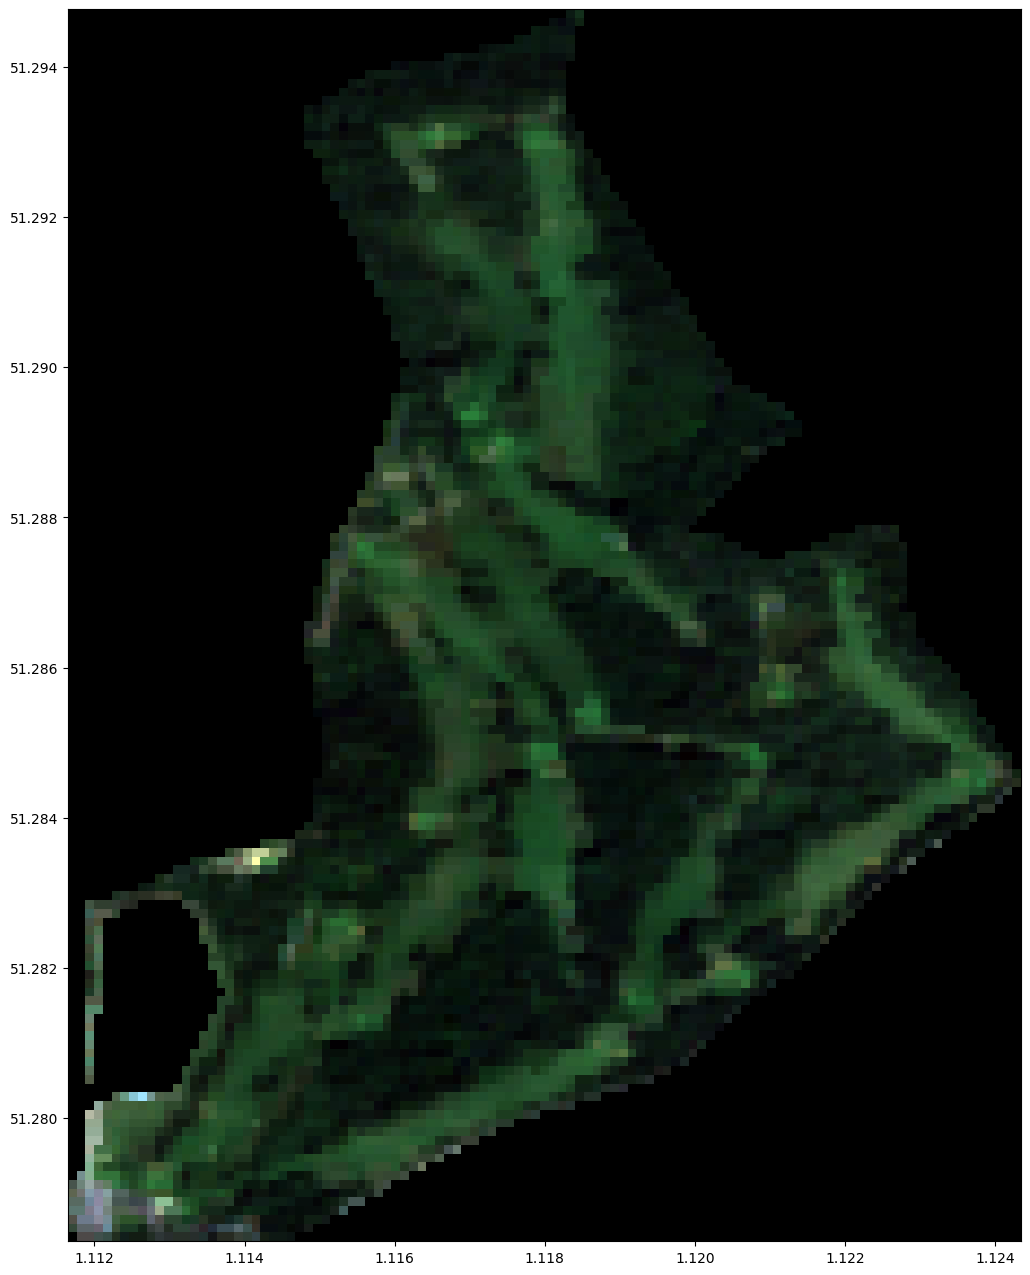

In [0]:
def get_example(df):
  example_key = "10687FB3-87DF-64A4-E063-AAEFA00A3B27"
  return df.where(f"id = '{example_key}'")

def get_path(df, colName):
  return df.transform(get_example).first()[colName]["raster"]

print(get_path(df=clipped_images, colName="tile"))
plot_file(get_path(df=clipped_images, colName="tile"), bands=[4, 3, 2])

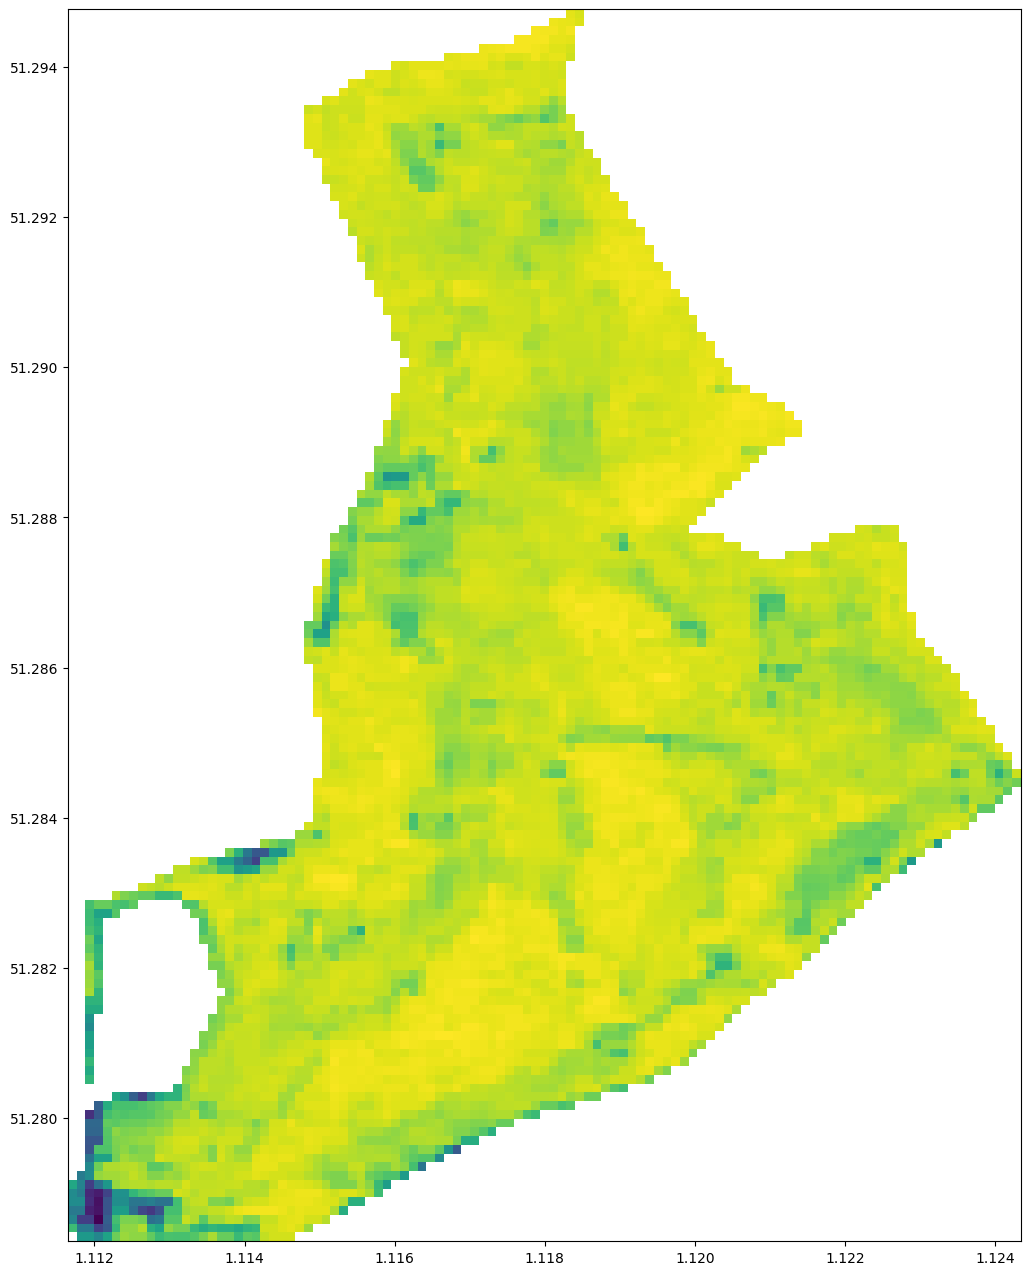

In [0]:
plot_file(get_path(df=ndvi, colName="ndvi"), bands=1)

## Apply zonal map algebra functions

In contrast to the 'local' map algebra functions, their 'zonal' equivalents aggregate the pixel values of the entire raster tile.

The following functions are implemented:
- `rst_min()`
- `rst_max()`
- `rst_avg()` (computes the mean pixel value)
- `rst_median()`
- `rst_pixelcount()`

If the `tile` object passed to any of these functions is a multiband raster, an array of values will be returned.

In [0]:
(
  clipped_images
  .withColumn("max_per_band", F.expr("rst_max(tile)"))
  .limit(5)
  ).display()

id,item_id,datetime,tile,function,distinctive_name_1,distinctive_name_2,distinctive_name_3,distinctive_name_4,geometry,geometry_srid,geometry_4326,max_per_band
10687FF9-1ECE-64A4-E063-AAEFA00A3B27,S2A_MSIL2A_20210720T110621_R137_T30UXC_20210720T224109,2021-07-20T11:06:21.024000Z,"List(null, /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/outputs/checkpoint/2024-09-10T16:05:15.156604/raster_55cd4d2a_4a4e_4048_be2f_0580430c6bc1.tif, Map(path -> /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/outputs/checkpoint/2024-09-10T16:05:15.156604/raster_55cd4d2a_4a4e_4048_be2f_0580430c6bc1.tif, last_error -> the source raster dataset has a SRS, but the cutline features not. We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect., all_parents -> /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/imagery/T30UXC_20210720T110621_B01_60m.tif, driver -> GTiff, parentPath -> /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/imagery/T30UXC_20210720T110621_B01_60m.tif, last_command -> gdalwarp -wo CUTLINE_ALL_TOUCHED=TRUE -cutline /tmp/mosaic_tmp/mosaic7102741701727800675/raster_9d98a096_ea0c_45e8_a633_fb12036f543a..shp -crop_to_cutline -of GTiff -co TILED=YES -co COMPRESS=DEFLATE))",Golf Course,,,,,"MULTIPOLYGON (((458797.06 161466.21,458786.47 161484.72,458784.58 161488.73,458779.0 161483.6,458692.7 161665.0,458574.88 161571.57,458755.6 161439.9,458765.47 161447.12,458783.9 161423.24,458804.22 161438.21,458793.37 161453.08,458794.04 161458.16,458800.75 161457.91,458797.06 161466.21)))",27700,"MULTIPOLYGON (((-1.1571228817491248 51.34924197593915, -1.1572718734288099 51.34940948772444, -1.157298347640004 51.349445735661625, -1.1573793073226355 51.34940018933296, -1.1585884824194246 51.35104000952942, -1.1602954742932856 51.350212139600835, -1.1577224701070759 51.349009709899285, -1.1575795745153226 51.34907360433031, -1.1573189078834105 51.348857003372096, -1.157024701563959 51.34898949625749, -1.157178025179782 51.349124308783836, -1.1571675681514262 51.34916991247416, -1.1570712722065302 51.34916697187142, -1.1571228817491248 51.34924197593915)))","List(475.0, 1148.0, 1478.0, 1734.0, 1728.0, 4057.0, 5041.0, 5760.0, 5595.0, 5444.0, 3136.0, 1823.0)"
10687FB5-6AE6-64A4-E063-AAEFA00A3B27,S2B_MSIL2A_20210721T113319_R080_T30UVD_20210721T214240,2021-07-21T11:33:19.024000Z,"List(null, /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/outputs/checkpoint/2024-09-10T16:05:15.156604/raster_0bb711f6_518a_4b5a_ab8d_2e2892d19f29.tif, Map(path -> /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/outputs/checkpoint/2024-09-10T16:05:15.156604/raster_0bb711f6_518a_4b5a_ab8d_2e2892d19f29.tif, last_error -> the source raster dataset has a SRS, but the cutline features not. We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect., all_parents -> /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/imagery/T30UVD_20210721T113319_B01_60m.tif, driver -> GTiff, parentPath -> /dbfs/tmp/stuart.lynn@databricks.com/OpenGreenspace/imagery/T30UVD_20210721T113319_B01_60m.tif, last_command -> gdalwarp -wo CUTLINE_ALL_TOUCHED=TRUE -cutline /tmp/mosaic_tmp/mosaic8450307178663622/raster_97321d05_07e7_4514_a99e_efb28922f091..shp -crop_to_cutline -of GTiff -co TILED=YES -co COMPRESS=DEFLATE))",Golf Course,,,,,"MULTIPOLYGON (((254840.77 337372.17,254881.77 337365.69,254886.57 337397.59,254923.57 337391.49,254919.37 337359.66,254926.17 337359.79,254925.17 337447.45,254920.27 337476.65,254891.87 337486.55,254858.49 337505.83,254821.07 337508.37,254803.67 337515.67,254800.67 337506.45,254695.52 337545.74,254642.57 337577.84,254615.34 337530.33,254616.49 337520.22,254634.1 337501.21,254637.57 337489.56,254611.39 337409.22,254840.77 337372.17)),((255283.86 337410.34,255289.11 337410.98,255306.53 337428.95,255351.85 337487.8,255246.37 337455.16,255217.7 337470.02,255163.16 337476.53,255130.04 337511.54,255092.33 337519.97,255079.39 337519.3,255083.62 33

The final part of this workflow is to take our computed NDVI tiles and turn them into a single value. In this case, we'll compute the mean value to try and express the relative healthiness of the vegetation of each green space.

We can then sort these values to identify the healthiest (or least healthy) golf courses in our great nation.

In [0]:
mean_ndvi = (
  ndvi
  .withColumn("ndvi_mean_test", F.expr("try_sql(rst_avg(ndvi))"))
  .where("ndvi_mean_test.status='OK'")
  .select(
    "id", "function", "distinctive_name_1",
    "ndvi.metadata.path",
    F.explode(F.col("ndvi_mean_test.result")).alias("ndvi_mean")
    )
).cache()

Let's look at the areas with the highest and lowest NDVI and see what we can conclude...

ID: 10688007-AB42-64A4-E063-AAEFA00A3B27
Location: 
Mean NDVI: 0.911


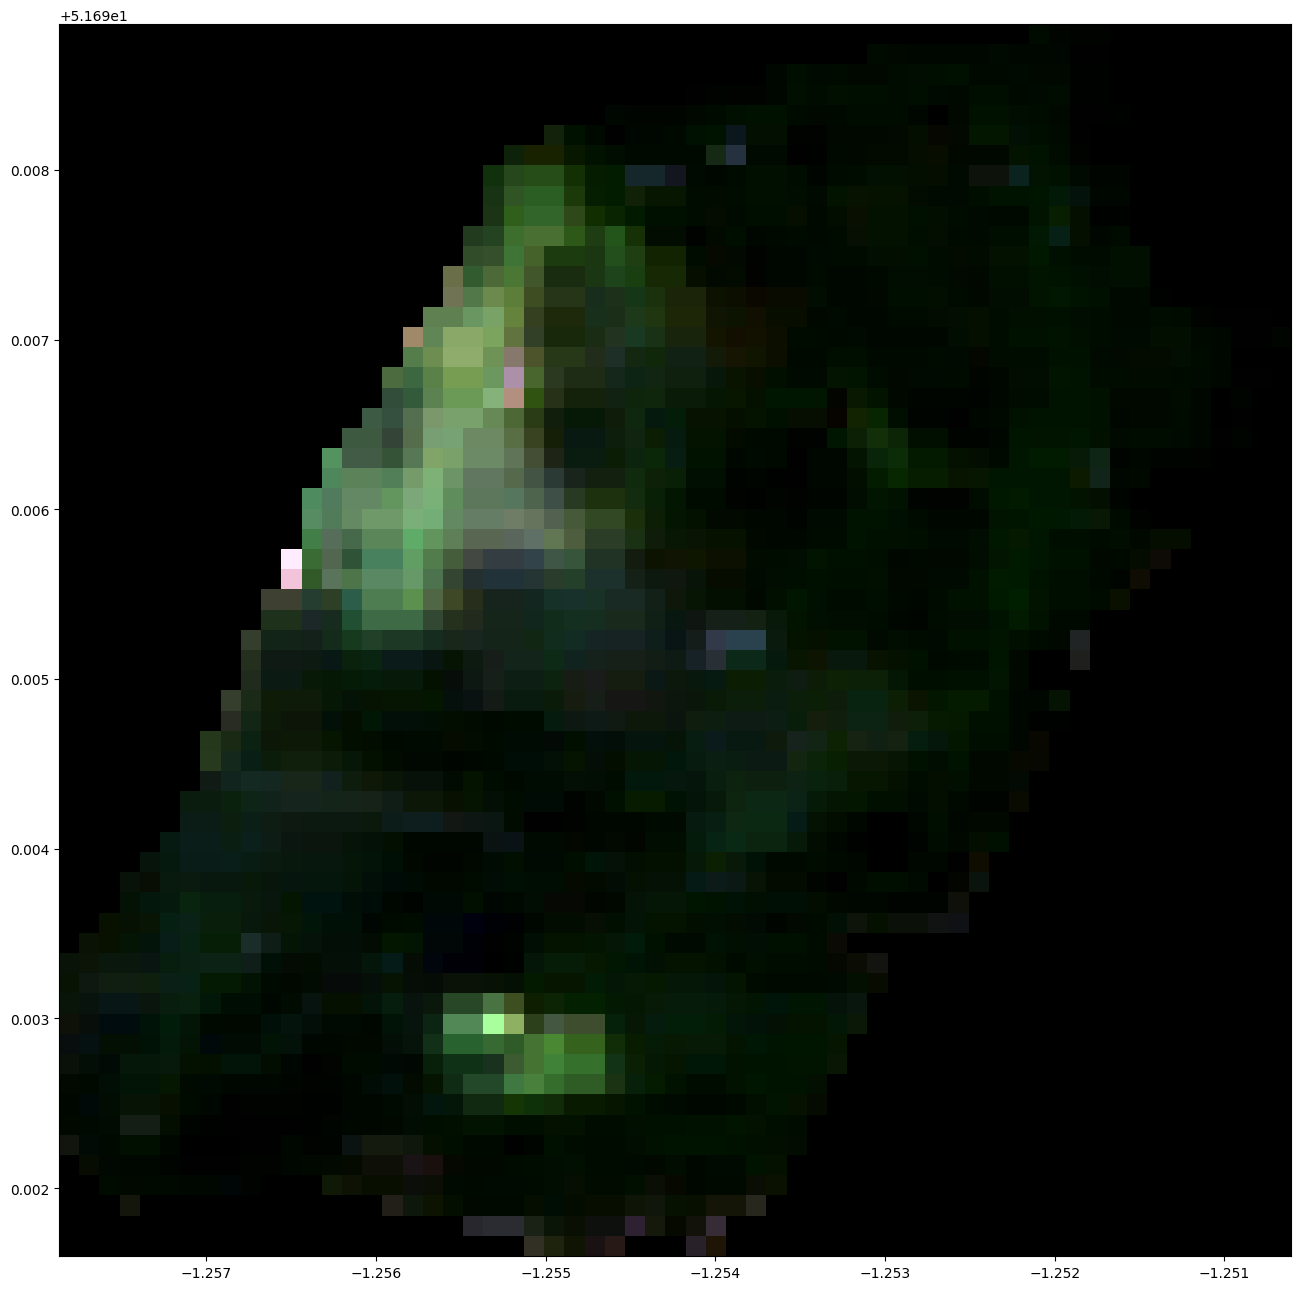

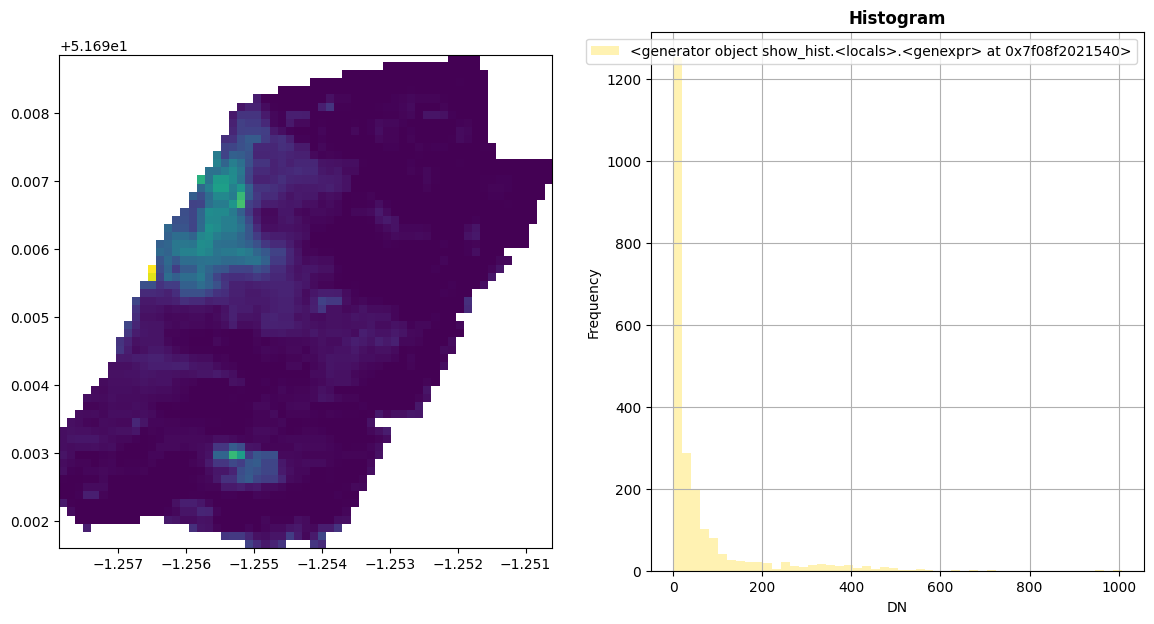

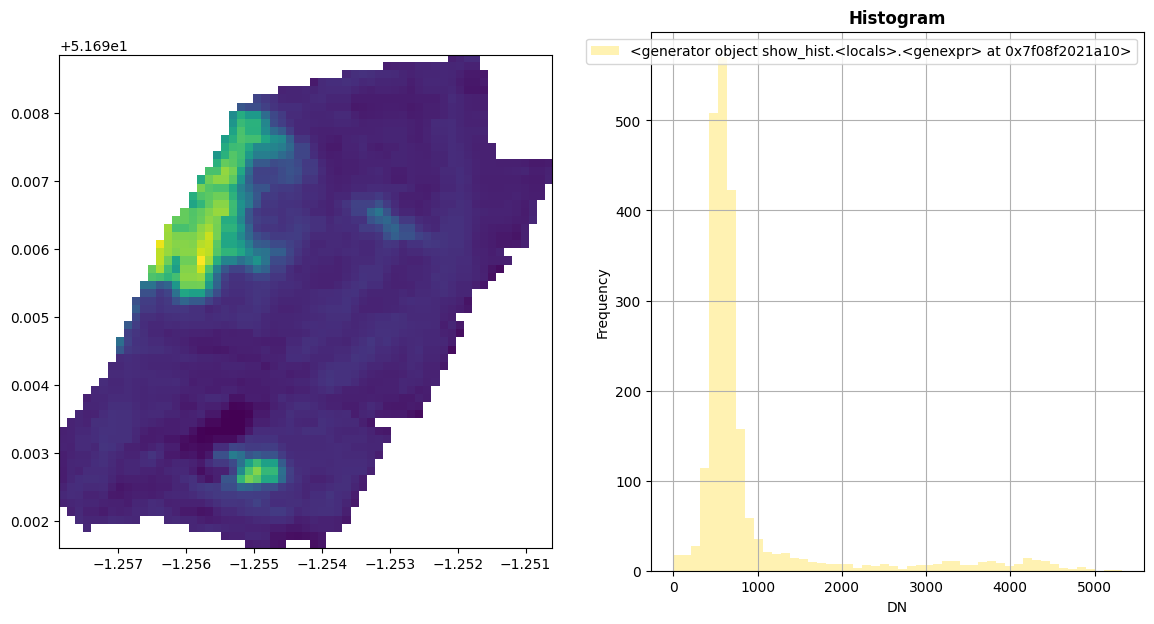

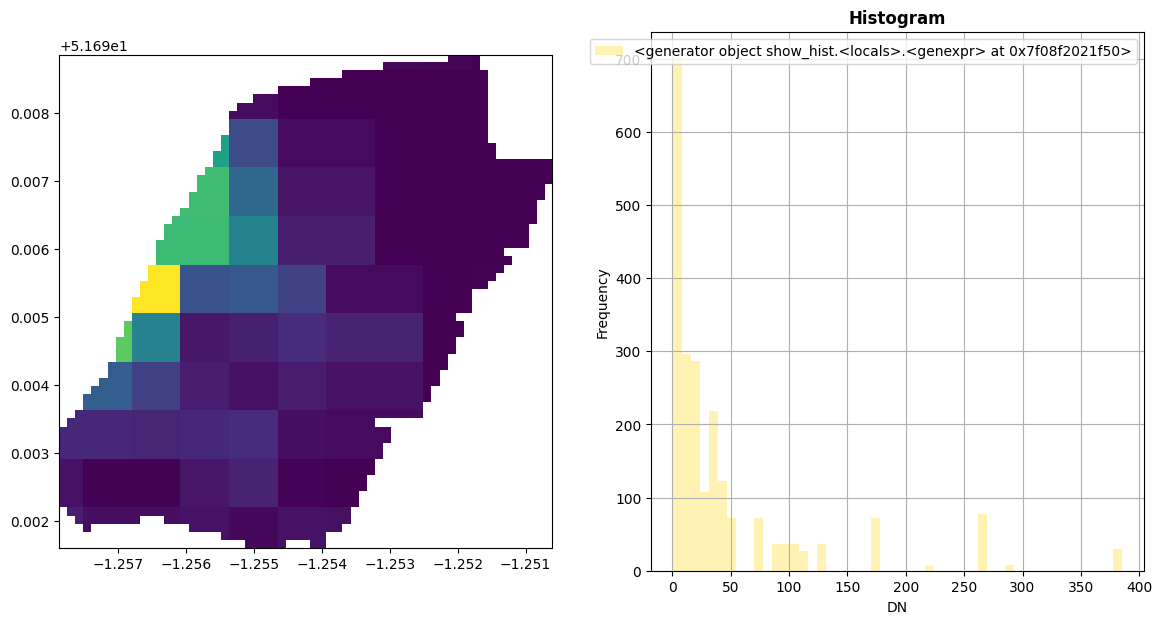

'MULTIPOLYGON (((-1.2568227676773496 51.69483798609326, -1.2569440080612002 51.69454653422479, -1.256915651326783 51.69444043697331, -1.254540982203054 51.69391325176267, -1.2530455062252108 51.69353079558381, -1.2528952429908295 51.69352732287335, -1.2525752971902875 51.69362778981835, -1.2520179503876108 51.69483339939863, -1.2521001336801656 51.69502633708902, -1.2519307931167507 51.695117870124434, -1.2517814166574623 51.69547279642808, -1.2516788282761593 51.69545568911133, -1.251655200069163 51.69551982673472, -1.2516105862567901 51.6955141478444, -1.25160792272055 51.69545631657348, -1.251513959989473 51.6956882342145, -1.2513925938352586 51.69566920879016, -1.2513779830972551 51.69575678127583, -1.2512879218959758 51.69583101550312, -1.2514268991426944 51.6959402464195, -1.2514072585485583 51.69605206348082, -1.2513314513644738 51.69608664681543, -1.2510591881893525 51.69610199566484, -1.2506722583593257 51.69721733240007, -1.2507319529961163 51.69728245060916, -1.2515328184528

In [0]:
high_ndvi_id = (
  mean_ndvi
  .orderBy(F.desc("ndvi_mean"))
  .first()["id"]
  )

high_mean = mean_ndvi.where(f"id='{high_ndvi_id}'").first()
high_ndvi_row = ndvi.where(f"id='{high_ndvi_id}'").first()
high_ndvi_original_row = clipped_images.where(f"id='{high_ndvi_id}'").first()

print(f"ID: {high_mean['id']}")
print(f"Location: {high_mean['distinctive_name_1']}")
print(f"Mean NDVI: {high_mean['ndvi_mean']}")

plot_file(high_ndvi_original_row["tile"]["raster"], [4, 3, 2])
plot_file_with_hist(high_ndvi_original_row["tile"]["raster"], 4)
plot_file_with_hist(high_ndvi_original_row["tile"]["raster"], 8)
plot_file_with_hist(high_ndvi_row["tile"]["raster"], 1)

high_ndvi_row["geometry_4326"]

ID: 10687FCF-73A2-64A4-E063-AAEFA00A3B27
Location: Moray Golf Course
Mean NDVI: -0.027


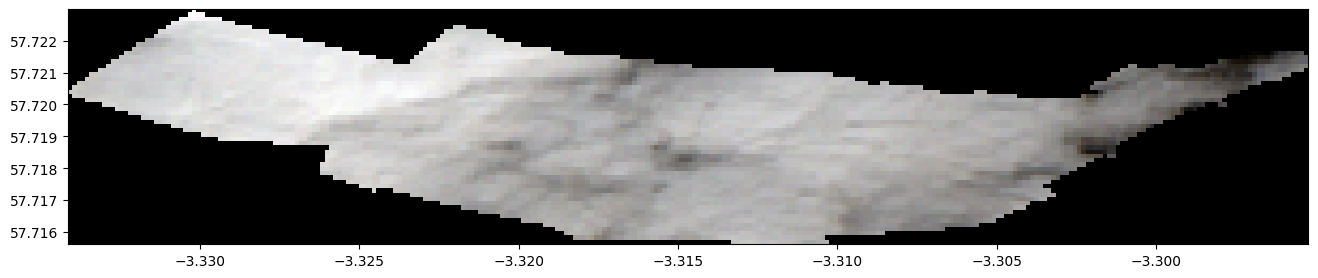

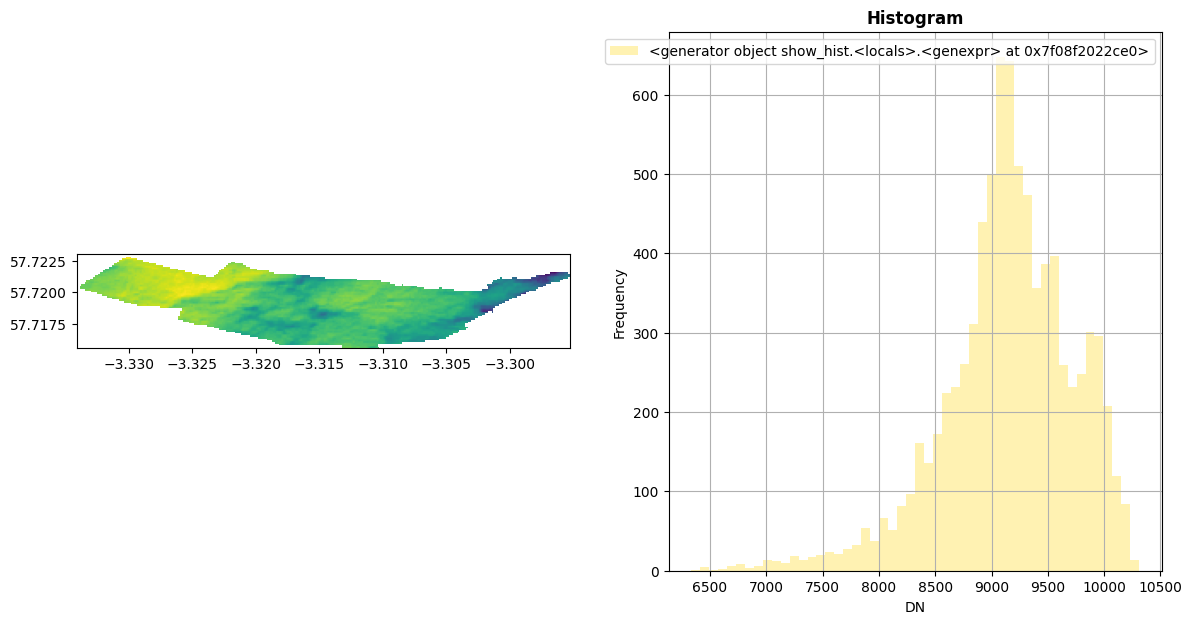

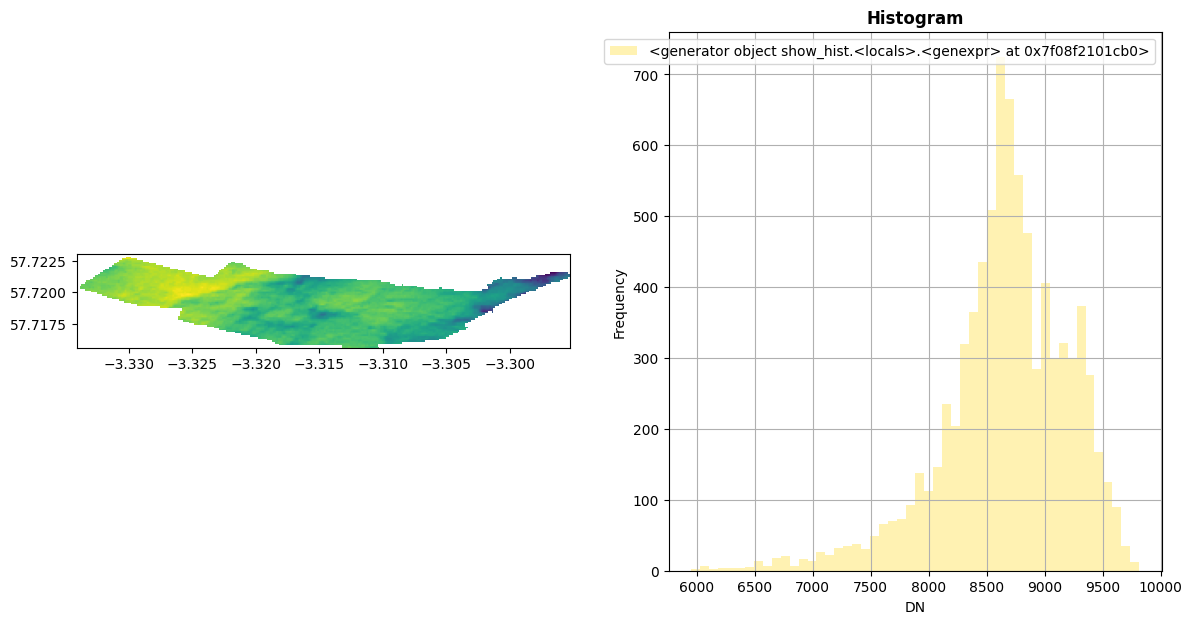

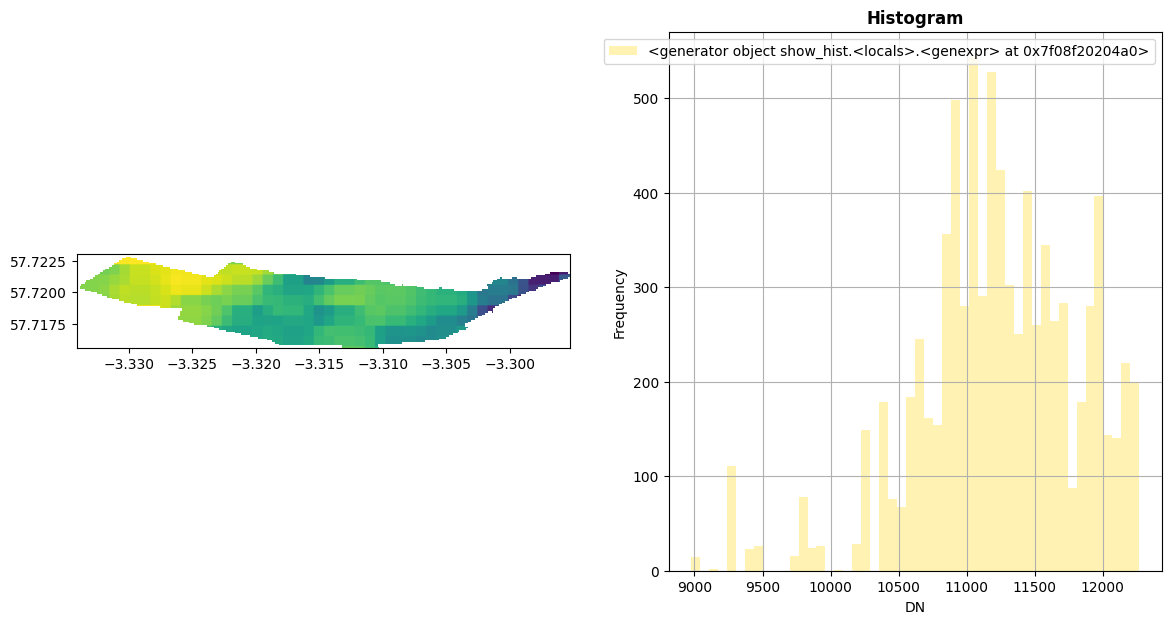

'MULTIPOLYGON (((-3.3286548815295602 57.71887941681793, -3.327323990742645 57.71882133166639, -3.324309398662346 57.71881238701741, -3.3215263144600145 57.71880805098075, -3.3205455329583815 57.71875180918967, -3.3198308054289476 57.7186254123902, -3.319151837053793 57.71842048505219, -3.3181899520042597 57.71796939577757, -3.3180121975119294 57.7178777312465, -3.316730187709751 57.71723655490519, -3.3162610713722422 57.71707704049428, -3.315449405815669 57.71691479591705, -3.313951065317469 57.716786894088806, -3.31334304959318 57.716694387912895, -3.3129291979602935 57.71656770546396, -3.311990858848866 57.71616070258527, -3.311250482598466 57.71596337664967, -3.3104859905292563 57.7158927795476, -3.308214034531893 57.7160396170249, -3.3063775994619764 57.71617042165806, -3.305798092516098 57.71625338633624, -3.3051013824412383 57.7164101408486, -3.304104256315208 57.71686759957325, -3.304022072568816 57.71695827803013, -3.3037104146405487 57.7170630877306, -3.303579995366143 57.7170

In [0]:
low_ndvi_id = (
  mean_ndvi
  .where(~(F.col("id")=="10687FF5-AFE1-64A4-E063-AAEFA00A3B27"))
  .orderBy("ndvi_mean")
  .first()["id"]
  )

low_mean = mean_ndvi.where(f"id='{low_ndvi_id}'").first()
low_ndvi_row = ndvi.where(f"id='{low_ndvi_id}'").first()
low_ndvi_original_row = clipped_images.where(f"id='{low_ndvi_id}'").first()

print(f"ID: {low_mean['id']}")
print(f"Location: {low_mean['distinctive_name_1']}")
print(f"Mean NDVI: {low_mean['ndvi_mean']}")

plot_file(low_ndvi_original_row["tile"]["raster"], [4, 3, 2])
plot_file_with_hist(low_ndvi_original_row["tile"]["raster"], 4)
plot_file_with_hist(low_ndvi_original_row["tile"]["raster"], 8)
plot_file_with_hist(low_ndvi_row["tile"]["raster"], 1)

low_ndvi_row["geometry_4326"]